# Twitter Sentiment Analysis - POC
---

## 7. Quickly train various models

**Current State**: I've trained three baseline models with little tweaking, fine-tuned a single decision tree, and trained a few random forests on a Bag-of-Word subset of $m\approx250k, n=50k$ of the training data, using cross validation, and got the following mean accuracy scores:

- Logistic Regression: $78.8\%$
- Naive Bayes: $77.6\%$ 
- SGD (log loss): $77.1\%$ 
- Random Forests: $75.0\%$
- Decision Tree: $69.0\%$

**This Notebook**: since the previous notebook's random forests were built on few instances, I'm choosing a couple of the best ones to train on the entire training data (for th POC) and plotting some learning curves.

In [1]:
import re
import os
import time
import json

import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt

from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score

### Load $m\approx250k$, $n=50k$ training subset

In [2]:
# processed dir
proc_dir = os.path.join("..","data","3_processed","sentiment140")
X_train_transformed = sp.load_npz(os.path.join(proc_dir, "X_train_transformed_BoW_250k_50k.npz"))
with open(os.path.join(proc_dir, "y_array_250k.npy"), 'rb') as f:
    y_array = np.load(f)

In [3]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_transformed, 
                                                      y_array, 
                                                      test_size=0.2, 
                                                      random_state=42)

### Define functions

These are helper functions for getting data for plotting the learning curves.

In [8]:
#def get_learning_data(rf_clf):
#    xs, train_acc, valid_acc = [], [], []
#    for m_instances in range(1004, 201174, 22241):
#        rf_clf.fit(X_train[:m_instances], y_train[:m_instances])
#        y_train_predict = rf_clf.predict(X_train[:m_instances])
#        y_valid_predict = rf_clf.predict(X_valid)
#        train_acc.append(accuracy_score(y_train[:m_instances], y_train_predict))
#        valid_acc.append(accuracy_score(y_valid, y_valid_predict))
#        xs.append(str(m_instances)) 
#    return xs, train_acc, valid_acc

In [9]:
def plot_learning_curve(xs, train_acc, valid_acc):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_axes([0.0, X_train.shape[0], 0.4, 0.8])
    plt.plot(xs, train_acc, 'r--', linewidth=.8, label="train accuracy")
    plt.plot(xs, valid_acc, 'b--', linewidth=.8, label="validation accuracy")
    plt.xticks(rotation=45)
    plt.title(''.join(["Learning Rates for Training and Validation"]), fontsize=16)
    plt.legend(loc="lower right", fontsize=14)
    plt.xlabel("Training Set Size", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.show()

### Random Forest 1

This is a small forest of 300 trees which uses `max_features="sqrt"` as a limiting factor.

In [15]:
rf_clf = RandomForestClassifier(n_estimators=300,
                                 max_samples=None, 
                                 max_features="sqrt",
                                 max_depth=None,
                                 random_state=42,
                                 n_jobs=-1, 
                                 verbose=0)

In [35]:
xs, train_acc, valid_acc, loop_ix = [], [], [], 0
for m_instances in range(1000, 101000, 5500):
    loop_ix += 1
    start_loop = time.time()
    rf_clf.fit(X_train[:m_instances], y_train[:m_instances])
    y_train_predict = rf_clf.predict(X_train[:m_instances])
    y_valid_predict = rf_clf.predict(X_valid)
    train_acc.append(accuracy_score(y_train[:m_instances], y_train_predict))
    valid_acc.append(accuracy_score(y_valid, y_valid_predict))
    xs.append(str(m_instances))
    mins, secs = divmod(time.time() - start_loop, 60)
    print(f'Loop {loop_ix:0.0f} | {m_instances:0.0f} instances trained | elapsed {mins:0.0f}m {secs:0.0f}s')

Loop 1 | 1000 instances trained | elapsed 0m 4s 
Loop 2 | 6500 instances trained | elapsed 0m 23s 
Loop 3 | 12000 instances trained | elapsed 0m 50s 
Loop 4 | 17500 instances trained | elapsed 1m 15s 
Loop 5 | 23000 instances trained | elapsed 1m 41s 
Loop 6 | 28500 instances trained | elapsed 2m 10s 
Loop 7 | 34000 instances trained | elapsed 2m 38s 
Loop 8 | 39500 instances trained | elapsed 3m 10s 
Loop 9 | 45000 instances trained | elapsed 3m 43s 
Loop 10 | 50500 instances trained | elapsed 4m 15s 
Loop 11 | 56000 instances trained | elapsed 4m 51s 
Loop 12 | 61500 instances trained | elapsed 5m 30s 
Loop 13 | 67000 instances trained | elapsed 6m 10s 
Loop 14 | 72500 instances trained | elapsed 6m 48s 
Loop 15 | 78000 instances trained | elapsed 7m 30s 
Loop 16 | 83500 instances trained | elapsed 8m 10s 
Loop 17 | 89000 instances trained | elapsed 8m 57s 
Loop 18 | 94500 instances trained | elapsed 9m 43s 
Loop 19 | 100000 instances trained | elapsed 10m 29s 


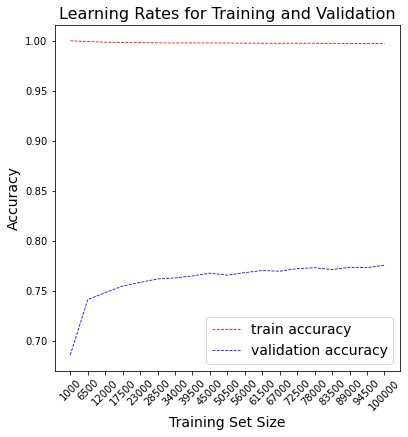

In [36]:
plot_learning_curve(xs, train_acc, valid_acc)

In [38]:
print(f'Min training accuracy: {min(train_acc):0.4f}')
print(f'Max validation accuracy: {max(valid_acc):0.4f}')

Min training accuracy: 0.9974
Max validation accuracy: 0.7754


### Random Forest 2

This is a 1,000-tree forest that uses `max_features=200` as its limiting factor.

In [39]:
rf_clf2 = RandomForestClassifier(n_estimators=1000, # the grid search params
                                 max_samples=None, # 8000 was the max then, got 75% accuracy as well
                                 max_features=200, 
                                 max_depth=None,
                                 random_state=42,
                                 n_jobs=-1, 
                                 verbose=0)

In [45]:
xs, train_acc2, valid_acc2, loop_ix = [], [], [], 0
for m_instances in range(5000, 125000, 25000):
    loop_ix += 1
    start_loop = time.time()
    rf_clf2.fit(X_train[:m_instances], y_train[:m_instances])
    y_train_predict = rf_clf2.predict(X_train[:m_instances])
    y_valid_predict = rf_clf2.predict(X_valid)
    train_acc2.append(accuracy_score(y_train[:m_instances], y_train_predict))
    valid_acc2.append(accuracy_score(y_valid, y_valid_predict))
    xs.append(str(m_instances))
    mins, secs = divmod(time.time() - start_loop, 60)
    print(f'Loop {loop_ix:0.0f} | {m_instances:0.0f} instances trained | elapsed {mins:0.0f}m {secs:0.0f}s')

Loop 1 | 5000 instances trained | elapsed 1m 6s 
Loop 2 | 30000 instances trained | elapsed 7m 48s 
Loop 3 | 55000 instances trained | elapsed 16m 3s 
Loop 4 | 80000 instances trained | elapsed 26m 5s 
Loop 5 | 105000 instances trained | elapsed 37m 43s 


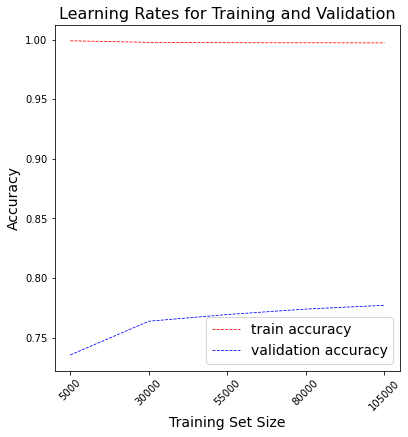

In [47]:
plot_learning_curve(xs, train_acc2, valid_acc2)

In [48]:
print(f'Min training accuracy: {min(train_acc2):0.4f}')
print(f'Max validation accuracy: {max(valid_acc2):0.4f}')

Min training accuracy: 0.9974
Max validation accuracy: 0.7771


### Random Forest 3

This is a large 10,000-tree forest which uses `max_leaf_nodes=99` as its main constraining factor.

In [49]:
rf_clf3 = RandomForestClassifier(n_estimators=10000, # the second DIY forest params
                                max_samples=None, # 2000 was the max then, got 75% accuracy
                                max_features="sqrt", 
                                max_leaf_nodes=99, 
                                random_state=42,
                                n_jobs=-1, 
                                verbose=0)

In [55]:
xs, train_acc3, valid_acc3, loop_ix = [], [], [], 0
for m_instances in range(10000, 170000, 50000):
    loop_ix += 1
    start_loop = time.time()
    rf_clf3.fit(X_train[:m_instances], y_train[:m_instances])
    y_train_predict = rf_clf3.predict(X_train[:m_instances])
    y_valid_predict = rf_clf3.predict(X_valid)
    train_acc3.append(accuracy_score(y_train[:m_instances], y_train_predict))
    valid_acc3.append(accuracy_score(y_valid, y_valid_predict))
    xs.append(str(m_instances))
    mins, secs = divmod(time.time() - start_loop, 60)
    print(f'Loop {loop_ix:0.0f} | {m_instances:0.0f} instances trained | elapsed {mins:0.0f}m {secs:0.0f}s')

Loop 1 | 10000 instances trained | elapsed 2m 25s
Loop 2 | 60000 instances trained | elapsed 15m 29s
Loop 3 | 110000 instances trained | elapsed 30m 55s
Loop 4 | 160000 instances trained | elapsed 47m 36s


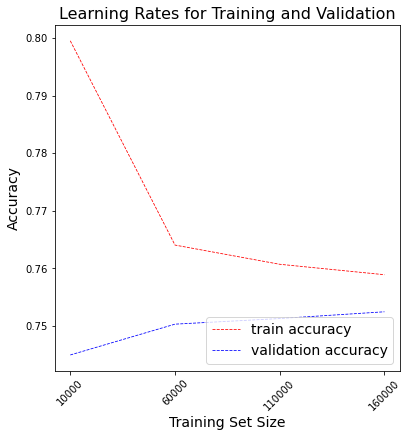

In [56]:
plot_learning_curve(xs, train_acc3, valid_acc3)

In [58]:
print(f'Min training accuracy: {min(train_acc3):0.4f}')
print(f'Max validation accuracy: {max(valid_acc3):0.4f}')

Min training accuracy: 0.7589
Max validation accuracy: 0.7525


---